In [ ]:
import numpy as np

full_data = np.load("./data/full_data.npy", allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

: 

In [2]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model("./models/mar9_tuned_1_classes")
model.summary()

2022-03-15 20:24:39.112388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-15 20:24:42.345526: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-15 20:24:42.346948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-15 20:24:42.376297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-15 20:24:42.377156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-03-15 20:24:42.378425: I

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 14, 8)]      0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 300)          279000      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
layer_normalization_1 (LayerNor (None, 300)          600         gru_1[0][0]                      
____________________________________________________________________________________________

In [3]:
import tensorflow as tf
# gpu setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
# Restrict TensorFlow to only use the second GPU
    try:
        tf.config.set_visible_devices(gpus[4], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Visible devices cannot be modified after being initialized


In [17]:
from tensorflow.keras.layers import Input, Dense, LSTM, AlphaDropout, Concatenate, LayerNormalization, GRU, Conv1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Precision, Recall, FalsePositives, TruePositives, CategoricalAccuracy
from tensorflow.keras.regularizers import l1, l2, l1_l2
from functools import partial

dense = partial(Dense, units=200, activation="selu", kernel_initializer="lecun_normal")
dropout = partial(AlphaDropout, rate=0.2)

obj_input = Input(shape=X_train_obj.shape[1:])
gru = GRU(200)(obj_input)
ln = LayerNormalization()(gru)
event_input = Input(shape=X_train_event.shape[1:])
hidden1 = dense()(event_input)
conc = Concatenate()([ln, hidden1])
do1 = dropout()(conc)
hidden2 = dense()(conc)
do2 = dropout()(hidden2)
hidden3 = dense()(hidden2)
do3 = dropout()(hidden3)
hidden4 = dense()(do3)
do4 = dropout()(hidden4)
hidden5 = dense()(do4)
do5 = dropout()(hidden5)
hidden6 = dense()(do5)
do6 = dropout()(hidden6)
out = Dense(1, activation="sigmoid")(do3)
combined_model = Model(inputs=[obj_input, event_input], outputs=out)
opt = Nadam(learning_rate=0.0005)
metrics = [AUC(name="auc"), BinaryAccuracy(), Precision(name="precision"), Recall(name="recall")]
combined_model.compile(optimizer=opt, loss="binary_crossentropy", metrics=metrics)

In [4]:
from sklearn.model_selection import train_test_split

X_train_event, X_valid_event, X_train_obj, X_valid_obj, y_train, y_valid = train_test_split(X_train_event, X_train_obj, y_train, test_size=0.1, stratify=y_train, random_state=42)

In [5]:
from sklearn.utils import class_weight

y_train, y_valid = y_train.values[:,-1], y_valid.values[:,-1]
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
d_class_weights = dict(enumerate(class_weights))
train_weights = np.array([d_class_weights[i] for i in y_train])
valid_weights = np.array([d_class_weights[i] for i in y_valid])


In [6]:
model.metrics[1].name

'auc_1'

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor="val_auc"),
    ReduceLROnPlateau(patience=5, monitor="val_auc"),
]
history = combined_model.fit(
    [X_train_obj, X_train_event],
    y_train,
    batch_size=256,
    epochs=50,
    callbacks=callbacks,
    validation_data=([X_valid_obj, X_valid_event], y_valid, valid_weights),
    sample_weight=train_weights,
    shuffle=True
)

Epoch 1/50
1151/1151 [==============================] - 23s 16ms/step - loss: 0.5594 - auc: 0.7909 - binary_accuracy: 0.7124 - precision: 0.4466 - recall: 0.7325 - val_loss: 0.5804 - val_auc: 0.8225 - val_binary_accuracy: 0.8029 - val_precision: 0.6002 - val_recall: 0.5636
Epoch 2/50
1151/1151 [==============================] - 12s 11ms/step - loss: 0.5183 - auc: 0.8210 - binary_accuracy: 0.7465 - precision: 0.4852 - recall: 0.7361 - val_loss: 0.5413 - val_auc: 0.8231 - val_binary_accuracy: 0.7592 - val_precision: 0.5030 - val_recall: 0.7085
Epoch 3/50
1151/1151 [==============================] - 12s 11ms/step - loss: 0.5112 - auc: 0.8265 - binary_accuracy: 0.7536 - precision: 0.4950 - recall: 0.7361 - val_loss: 0.5379 - val_auc: 0.8275 - val_binary_accuracy: 0.7732 - val_precision: 0.5251 - val_recall: 0.6892
Epoch 4/50
1151/1151 [==============================] - 13s 11ms/step - loss: 0.5075 - auc: 0.8299 - binary_accuracy: 0.7580 - precision: 0.5023 - recall: 0.7380 - val_loss: 0.52

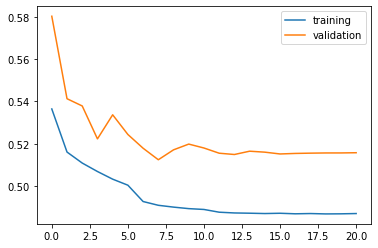

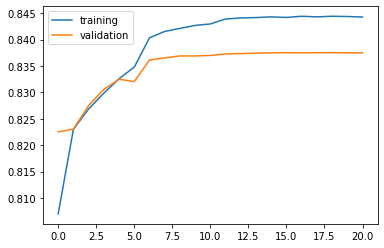

In [20]:
import matplotlib.pyplot as plt 

epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], label='training')
plt.plot(epochs, history.history['val_loss'], label='validation')
plt.legend()
plt.show()
plt.plot(epochs, history.history['auc'], label='training')
plt.plot(epochs, history.history['val_auc'], label='validation')
plt.legend()

In [23]:
model.save("./RNN_tuned_model")

2022-02-22 14:29:32.348204: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./RNN_tuned_model/assets


INFO:tensorflow:Assets written to: ./RNN_tuned_model/assets


In [21]:
y_pred = model.predict([X_test_obj, X_test_event])
y_pred = y_pred.reshape(y_pred.shape[0])

thresholds = np.arange(0, 1.0001, 0.0001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))
lr_FP = np.zeros(len(thresholds))
lr_TP = np.zeros(len(thresholds))

test = y_test.values[:, -1]
y_pred = y_pred.reshape(len(test))

for idx, threshold in enumerate(thresholds):
    FP[idx] = ((y_pred >= threshold) & (test == 0)).sum()
    FN[idx] = ((y_pred < threshold) & (test == 1)).sum()
    TP[idx] = ((y_pred >= threshold) & (test == 1)).sum()
    TN[idx] = ((y_pred < threshold) & (test == 0)).sum()

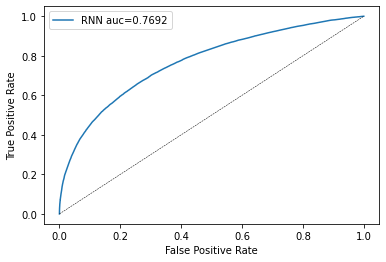

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test, y_pred)

# ROC curve
tpr = TP / (np.sum(test))
fpr = FP / (len(test) - np.sum(test))
tpr_lr = lr_TP / np.sum(test)
fpr_lr = lr_FP / (len(test) - np.sum(test))
plt.plot(fpr, tpr, label=f"RNN auc={auc:.4f}")
plt.plot(
    np.arange(0, 1.001, 0.001),
    np.arange(0, 1.001, 0.001),
    linestyle="dashed",
    linewidth=0.5,
    color="k",
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [13]:
f1 = TP / (TP + 0.5 * (FP + FN))
thresholds[np.argmax(f1)]

0.5845

In [14]:
np.max(f1)

0.5371105815903274

In [63]:
# Significance

# load xs weights
train_weights, test_weights = np.load("./data/weights.npy", allow_pickle=True)

significance_sigma0 = np.zeros(len(thresholds))
significance_sigma5 = np.zeros(len(thresholds))
significance_sigma10 = np.zeros(len(thresholds))
ams = np.zeros(len(thresholds))

lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.1
epsilon = 1e-4

for idx, threshold in enumerate(thresholds):
    sg[idx] = (
        lum * test_weights * 5 * ((y_pred >= threshold) & (test == 1)).astype(int)
    ).sum()
    bg[idx] = (
        lum * test_weights * 5 * ((y_pred >= threshold) & (test == 0)).astype(int)
    ).sum()
    if bg[idx] > 0:
        significance_sigma0[idx] = sg[idx] / np.sqrt(bg[idx])
        significance_sigma5[idx] = sg[idx] / np.sqrt(bg[idx] + (0.05 * bg[idx]) ** 2)
        significance_sigma10[idx] = sg[idx] / np.sqrt(bg[idx] + (0.1 * bg[idx]) ** 2)
        ams[idx] = np.sqrt(2 * ((sg[idx] + bg[idx] + 10) * np.log(1 + sg[idx]/(bg[idx] + 10)) - sg[idx]))


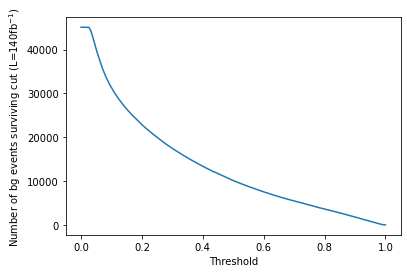

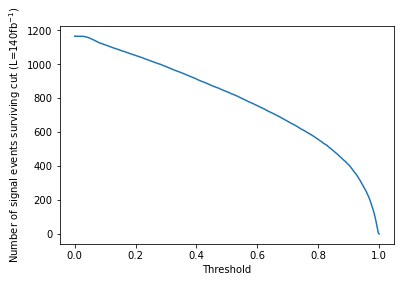

In [64]:
import matplotlib.pyplot as plt

# bg surviving
plt.plot(thresholds, bg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of bg events surviving cut (L=140fb$^{-1}$)")
plt.show()

# sg surviving
plt.plot(thresholds, sg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of signal events surviving cut (L=140fb$^{-1}$)")
plt.show()

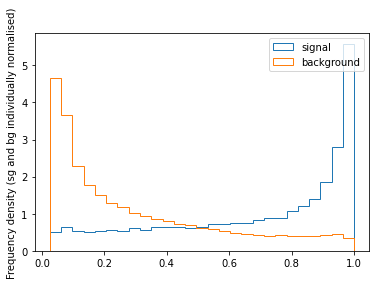

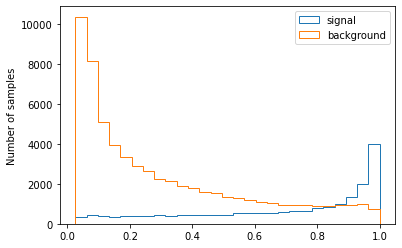

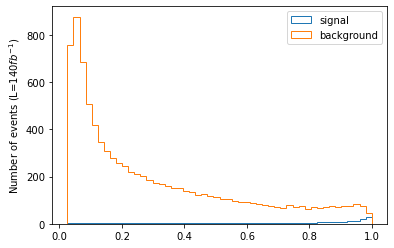

In [65]:
y_test = y_test.values
hist_sg, bins, patches = plt.hist(
    y_pred[y_test[:, -1] == 1],
    histtype="step",
    label="signal",
    density=True,
    bins="auto",
)
hist_bg, bins, patches = plt.hist(
    y_pred[y_test[:, -1] == 0],
    histtype="step",
    label="background",
    density=True,
    bins=bins,
)
plt.ylabel("Frequency density (sg and bg individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(
    y_pred[y_test[:, -1] == 1], histtype="step", label="signal", bins="auto"
)
hist_bg_counts, bins_counts, patches = plt.hist(
    y_pred[y_test[:, -1] == 0], histtype="step", label="background", bins=bins_counts
)
plt.ylabel("Number of samples")
plt.legend()
plt.show()

hist_sg_xs, bins_xs, patches = plt.hist(
    y_pred[y_test[:, -1] == 1],
    histtype="step",
    label="signal",
    bins=50,
    weights=lum * test_weights[y_test[:, -1] == 1],
)
hist_bg_xs, bins_xs, patches = plt.hist(
    y_pred[y_test[:, -1] == 0],
    histtype="step",
    label="background",
    bins=bins_xs,
    weights=lum * test_weights[y_test[:, -1] == 0],
)
plt.ylabel(r"Number of events (L=$140fb^{-1}$)")
plt.legend()
plt.show()

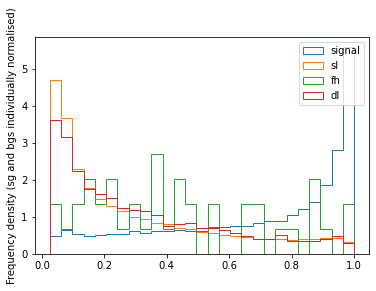

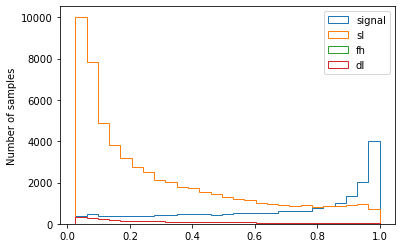

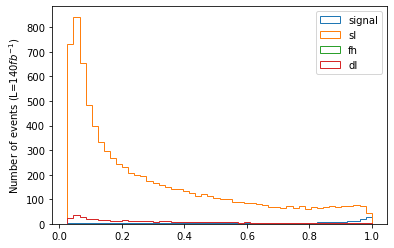

In [66]:
# Individual background analysis

hist_sg, bins, patches = plt.hist(
    y_pred[y_test[:, -1] == 1],
    histtype="step",
    label="signal",
    density=True,
    bins="auto",
)
hist_sl, bins, patches = plt.hist(
    y_pred[y_test[:, -2] == 1], histtype="step", label="sl", density=True, bins=bins
)
hist_fh, bins, patches = plt.hist(
    y_pred[y_test[:, -3] == 1], histtype="step", label="fh", density=True, bins=bins
)
hist_dl, bins, patches = plt.hist(
    y_pred[y_test[:, 0] == 1], histtype="step", label="dl", density=True, bins=bins
)
plt.ylabel("Frequency density (sg and bgs individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(
    y_pred[y_test[:, -1] == 1], histtype="step", label="signal", bins="auto"
)
hist_sl_counts, bins_counts, patches = plt.hist(
    y_pred[y_test[:, -2] == 1], histtype="step", label="sl", bins=bins_counts
)
hist_fh_counts, bins_counts, patches = plt.hist(
    y_pred[y_test[:, -3] == 1], histtype="step", label="fh", bins=bins_counts
)
hist_dl_counts, bins_counts, patches = plt.hist(
    y_pred[y_test[:, 0] == 1], histtype="step", label="dl", bins=bins_counts
)
plt.ylabel("Number of samples")
plt.legend()
plt.show()

hist_sg_xs, bins_xs, patches = plt.hist(
    y_pred[y_test[:, -1] == 1],
    histtype="step",
    label="signal",
    weights=140e3 * test_weights[y_test[:, -1] == 1],
    bins=50,
)
hist_sl_xs, bins_xs, patches = plt.hist(
    y_pred[y_test[:, -2] == 1],
    histtype="step",
    label="sl",
    weights=140e3 * test_weights[y_test[:, -2] == 1],
    bins=bins_xs,
)
hist_fh_xs, bins_xs, patches = plt.hist(
    y_pred[y_test[:, -3] == 1],
    histtype="step",
    label="fh",
    weights=140e3 * test_weights[y_test[:, -3] == 1],
    bins=bins_xs,
)
hist_dl_xs, bins_xs, patches = plt.hist(
    y_pred[y_test[:, 0] == 1],
    histtype="step",
    label="dl",
    weights=140e3 * test_weights[y_test[:, 0] == 1],
    bins=bins_xs,
)
plt.ylabel(r"Number of events (L=$140fb^{-1}$)")
plt.legend()
plt.show()

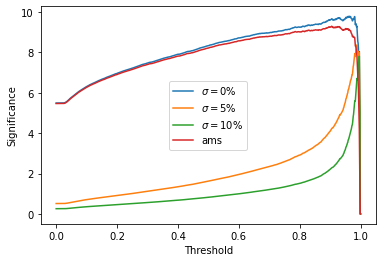

In [67]:
plt.plot(thresholds, significance_sigma0, label=r"$\sigma=0\%$")
plt.plot(thresholds, significance_sigma5, label=r"$\sigma=5\%$")
plt.plot(thresholds, significance_sigma10, label=r"$\sigma=10\%$")
plt.plot(thresholds, ams, label="ams")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.show()

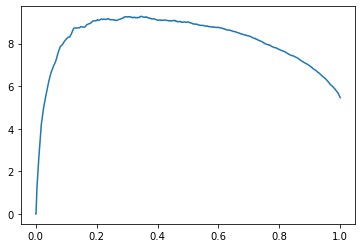

In [68]:
plt.plot(tpr, ams)

Best threshold for sigma=0% is 0.963 
Best threshold for sigma=5% is 0.988 
Best threshold for sigma=10% is 0.996


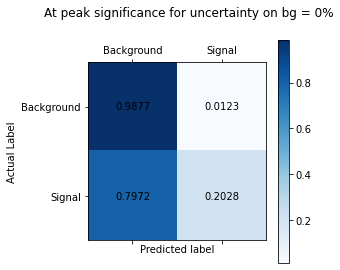

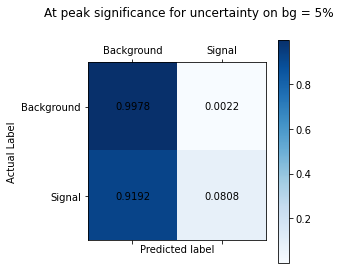

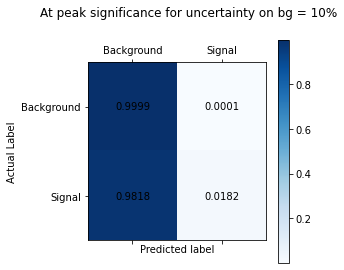

In [69]:
idx_0, idx_5, idx_10 = (
    np.argmax(significance_sigma0),
    np.argmax(significance_sigma5),
    np.argmax(significance_sigma10),
)
print(
    f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}"
)
label = {0: 0, 1: 5, 2: 10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1 - fpr[idx], fpr[idx]], [1 - tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap="Blues")
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel("Predicted label")
    plt.ylabel("Actual Label")
    plt.xticks([0, 1], labels=["Background", "Signal"])
    plt.yticks([0, 1], labels=["Background", "Signal"])
    plt.colorbar()
    plt.suptitle(f"At peak significance for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
    plt.show()

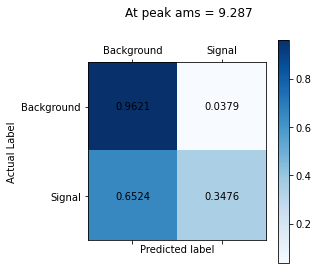

In [70]:
idx = np.argmax(ams)
conf_mat = [[1 - fpr[idx], fpr[idx]], [1 - tpr[idx], tpr[idx]]]
plt.matshow(conf_mat, cmap="Blues")
for (x, y), value in np.ndenumerate(conf_mat):
    plt.text(y, x, f"{value:.4f}", va="center", ha="center")
plt.xlabel("Predicted label")
plt.ylabel("Actual Label")
plt.xticks([0, 1], labels=["Background", "Signal"])
plt.yticks([0, 1], labels=["Background", "Signal"])
plt.colorbar()
plt.suptitle(f"At peak ams = {np.max(ams):.3f}")
# plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
plt.show()

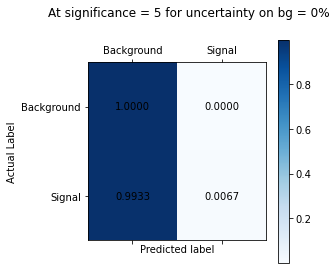

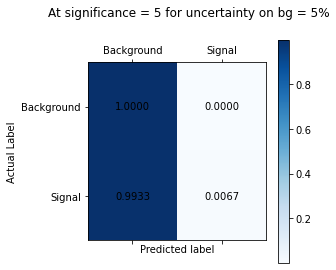

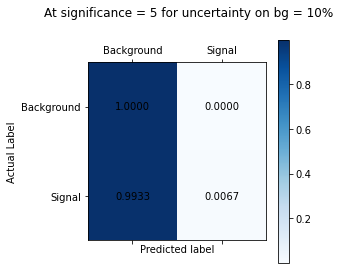

In [25]:
# conf matrices @ sig=5

idx_0, idx_5, idx_10 = (
    np.argmin(abs(5 - significance_sigma0)),
    np.argmin(abs(5 - significance_sigma5[:idx_5])),
    np.argmin(abs(5 - significance_sigma10[:idx_10])),
)
# print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2: 10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1 - fpr[idx], fpr[idx]], [1 - tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap="Blues")
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel("Predicted label")
    plt.ylabel("Actual Label")
    plt.xticks([0, 1], labels=["Background", "Signal"])
    plt.yticks([0, 1], labels=["Background", "Signal"])
    plt.colorbar()
    plt.suptitle(f"At significance = 5 for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}_sig_5.png", dpi=200)
    plt.show()